<a href="https://colab.research.google.com/github/junyi2022/musa-650-remote-sensing/blob/main/assignments/HW4/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MUSA 650 Homework 4: EuroSAT Land Use and Land Cover Classification using Machine Learning and Deep Learning

In this homework, we will explore land use and land cover (LULC) classification, comparing traditional machine learning and deep learning approaches.

**Data Source:** [EuroSAT RGB data](https://github.com/phelber/eurosat), [Zenndo data downloading](https://zenodo.org/records/7711810#.ZAm3k-zMKEA)

**Data Source Citation:**  

[1] Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.  

[2] Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.

**Disclaimer:** I consulted the following AI tool to revise code and answer questions for this project.

- DeepSeek. (n.d.). DeepSeek artificial intelligence system. Retrieved from https://www.deepseek.com

In [138]:
import os
import numpy as np
import pandas as pd
import rasterio
import random
from PIL import Image, ImageOps, ImageEnhance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, auc, RocCurveDisplay, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from collections import Counter
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from google.colab import drive
from tqdm import tqdm  # Progress bar


## 1. Data Loading, Processing, and Exploration

### 1.1 Data Loading

The data used in this project is downloaded from the EuroSAT RGB data. This project handles the zipfile from google drive. The files take time to appear on google drive so need to wait for a while. The EuroSAT RGB data has 10 folders and 27,000 files in total.

In [1]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab_Files/Import_Data/MUSA650_HW4/EuroSAT_RGB.zip' -d '/content/drive/MyDrive/Colab_Files'

### 1.2 Data Processing and Exploration

Assess the class distribution across the dataset and put them in a dataframe.

In [10]:
dataset_path = "/content/drive/MyDrive/Colab_Files/EuroSAT_RGB"

# Get main folders and file counts
data = []
for folder in os.listdir(dataset_path):
    folder_dir = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_dir):
        num_files = len([
            f for f in os.listdir(folder_dir)
            if os.path.isfile(os.path.join(folder_dir, f))
        ])
        data.append({'Folder': folder, 'File Count': num_files})

# Create and display DataFrame
df = pd.DataFrame(data)
df.style.set_properties(**{'text-align': 'left'}) \
       .set_caption("EuroSAT RGB Dataset Structure")

,Folder,File Count
0,Forest,3000
1,River,2500
2,Highway,2500
3,AnnualCrop,3000
4,SeaLake,3000
5,HerbaceousVegetation,3000
6,Industrial,2500
7,Residential,3000
8,PermanentCrop,2500
9,Pasture,2000


Plot one random image from each class.

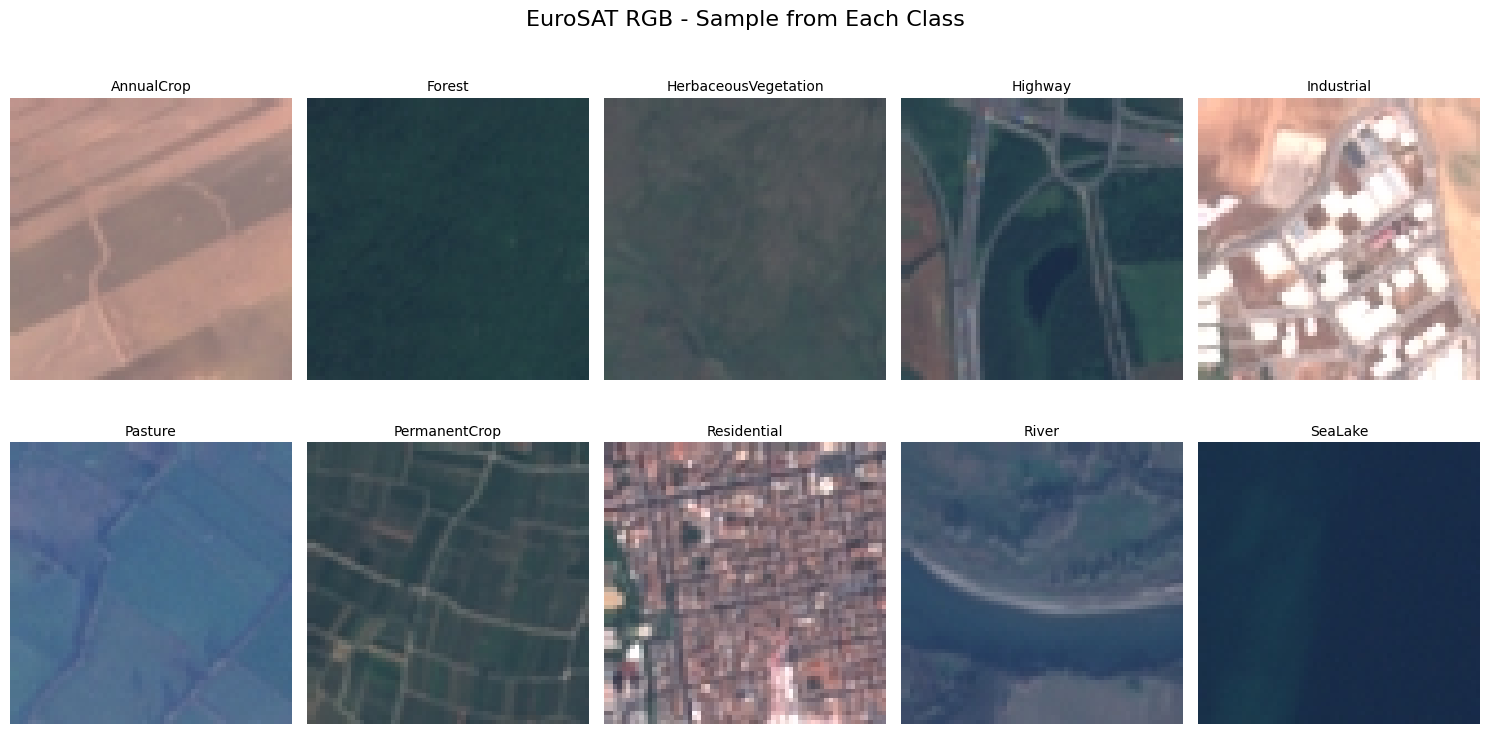

In [12]:
# Get all class folders (sorted alphabetically)
classes = sorted([d for d in os.listdir(dataset_path)
                 if os.path.isdir(os.path.join(dataset_path, d))])

# Set up plot
plt.figure(figsize=(15, 8))
plt.suptitle('EuroSAT RGB - Sample from Each Class', fontsize=16)

# Plot one random image per class
for i, class_name in enumerate(classes):
    # Get random image from class folder
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
    random_image = random.choice(images)

    # Load and plot image
    img = Image.open(os.path.join(class_path, random_image))
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(class_name, fontsize=10, pad=5)
    plt.axis('off')

plt.tight_layout()
plt.show()

Flatten the images into a 2D data matrix. Load these and the labels into the numpy arrays.

In [14]:
# Initialize data structures
x = []  # Flattened images (n_samples × 12288)
y = []  # Class labels (n_samples,)
class_names = []

# Process each class
for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg'))]

    # Process images with progress bar
    for img_file in tqdm(image_files, desc=f'Loading {class_name}'):
        img_path = os.path.join(class_dir, img_file)

        # Load, convert to array, and flatten
        img = np.array(Image.open(img_path))  # Shape (64, 64, 3)
        x.append(img.reshape(-1))  # Flatten to (12288,)
        y.append(class_idx)

    class_names.append(class_name)

# Convert to NumPy arrays
x = np.array(x, dtype=np.uint8)  # Shape (n_samples, 12288)
y = np.array(y)  # Shape (n_samples,)

# Verify shapes
print(f"Image data shape: {x.shape}")
print(f"Labels shape: {y.shape}")
print("Class mappings:", {i: name for i, name in enumerate(class_names)})

Loading SeaLake: 100%|██████████| 3000/3000 [00:46<00:00, 65.18it/s] 


Image data shape: (27000, 12288)
Labels shape: (27000,)
Class mappings: {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


Before splitting the data into training and testing sets or doing any preprocessing, apply data augmentation to increase the size of the dataset, appending the new samples to the original dataset.

**Augmentation Approaches:**

- Horizontal flipping (50% probability)

- Random rotation (90°, -90°, or 180°)

- Random brightness adjustment (80-120%)

In [62]:
# Data augmentation functions
def augment_image(img_array):
    """Apply random augmentations to an image array"""
    img = Image.fromarray(img_array)

    # Random horizontal flip
    if random.random() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)

    # Random rotation (90°, -90°, or 180°)
    if random.random() > 0.5:  # 50% chance to apply rotation
        rotation_angle = random.choice([90, -90, 180])
        img = img.rotate(rotation_angle, expand=False)  # expand=False keeps original dimensions

    # Random brightness adjustment
    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(random.uniform(0.8, 1.2))

    return np.array(img)

# Augment dataset
def augment_dataset(x_orig, y_orig, augment_factor=1):
    """Create augmented copies of the original dataset"""
    x_augmented = []
    y_augmented = []

    for _ in range(augment_factor):
        for i in tqdm(range(len(x_orig)), desc='Augmenting'):
            # Reshape to image format (64, 64, 3)
            img = x_orig[i].reshape(64, 64, 3)
            # Apply augmentations
            augmented_img = augment_image(img)
            # Flatten and store
            x_augmented.append(augmented_img.reshape(-1))
            y_augmented.append(y_orig[i])

    # Combine with original data
    x_full = np.concatenate([x_orig, np.array(x_augmented)])
    y_full = np.concatenate([y_orig, np.array(y_augmented)])

    return x_full, y_full

# Apply augmentation (2x original size)
x_aug, y_aug = augment_dataset(x, y, augment_factor=1)  # Double the dataset size

# Print new dataset size
print(f"Original dataset size: {len(x)}")
print(f"Augmented dataset size: {len(x_aug)}")
print(f"Augmentation multiplier: {len(x_aug)/len(x):.1f}x")

Augmenting: 100%|██████████| 27000/27000 [00:02<00:00, 13149.73it/s]


Original dataset size: 27000
Augmented dataset size: 54000
Augmentation multiplier: 2.0x


Plot three random images and a histogram of the label distribution across the full dataset.

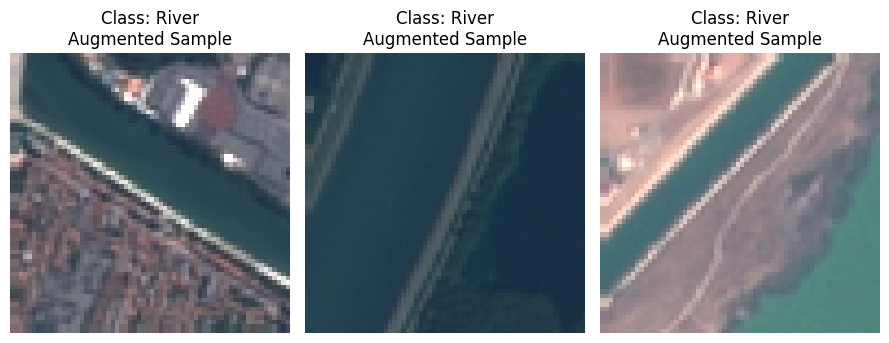

In [63]:
# Plot 3 random augmented images
plt.figure(figsize=(9, 4))
for i in range(3):
    idx = random.randint(len(x), len(x_aug)-1)  # Select from augmented portion
    img = x_aug[idx].reshape(64, 64, 3)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(f"Class: {class_names[y_aug[idx]]}\nAugmented Sample")
    plt.axis('off')
plt.tight_layout()
plt.show()

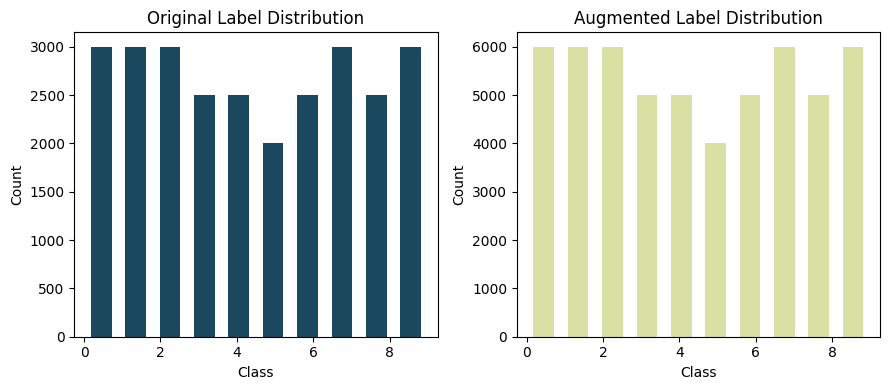

In [64]:
# Plot label distribution
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.hist(y, bins=len(class_names), rwidth=0.6, color='#19485F')
plt.title("Original Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(y_aug, bins=len(class_names), rwidth=0.6, color='#d9e0a4')
plt.title("Augmented Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Split the data into training (60%) and testing (40%) datasets, stratified on class labels (so that there is an equal percentage of each class type in each of the training and testing sets).

In [65]:
# Split the augmented data (stratified by class labels)
x_train, x_test, y_train, y_test = train_test_split(
    x_aug,          # Augmented image data (flattened)
    y_aug,          # Augmented labels
    test_size=0.4,  # 40% for testing
    stratify=y_aug, # Preserve class distribution
    random_state=42
)

print(f"Training set size: {len(x_train)} samples")
print(f"Testing set size: {len(x_test)} samples")

# Check class distribution
def print_class_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n{name} class distribution:")
    for cls, count in zip(unique, counts):
        print(f"{class_names[cls]}: {count} samples ({count/len(y):.1%})")

print_class_distribution(y_train, "Training")
print_class_distribution(y_test, "Testing")

Training set size: 32400 samples
Testing set size: 21600 samples

Training class distribution:
AnnualCrop: 3600 samples (11.1%)
Forest: 3600 samples (11.1%)
HerbaceousVegetation: 3600 samples (11.1%)
Highway: 3000 samples (9.3%)
Industrial: 3000 samples (9.3%)
Pasture: 2400 samples (7.4%)
PermanentCrop: 3000 samples (9.3%)
Residential: 3600 samples (11.1%)
River: 3000 samples (9.3%)
SeaLake: 3600 samples (11.1%)

Testing class distribution:
AnnualCrop: 2400 samples (11.1%)
Forest: 2400 samples (11.1%)
HerbaceousVegetation: 2400 samples (11.1%)
Highway: 2000 samples (9.3%)
Industrial: 2000 samples (9.3%)
Pasture: 1600 samples (7.4%)
PermanentCrop: 2000 samples (9.3%)
Residential: 2400 samples (11.1%)
River: 2000 samples (9.3%)
SeaLake: 2400 samples (11.1%)


Create a grayscale version of this dataset.



In [66]:
def convert_to_grayscale(x_data):
    """Convert flattened RGB images to grayscale (keeping channel dimension)"""
    # Reshape to (n_samples, 64, 64, 3), convert to grayscale, then re-flatten
    return np.array([
        np.array(Image.fromarray(img.reshape(64, 64, 3)).convert('L'))  # 'L' mode for grayscale
        .reshape(64*64)  # Flatten grayscale image
        for img in tqdm(x_data, desc='Converting to grayscale')
    ])

# Convert both training and testing sets
x_train_gray = convert_to_grayscale(x_train)
x_test_gray = convert_to_grayscale(x_test)

# Verify shapes
print(f"Original RGB shape - Train: {x_train.shape}, Test: {x_test.shape}")
print(f"Grayscale shape - Train: {x_train_gray.shape}, Test: {x_test_gray.shape}")

Converting to grayscale: 100%|██████████| 21600/21600 [00:00<00:00, 22768.74it/s]

Original RGB shape - Train: (32400, 12288), Test: (21600, 12288)
Grayscale shape - Train: (32400, 4096), Test: (21600, 4096)


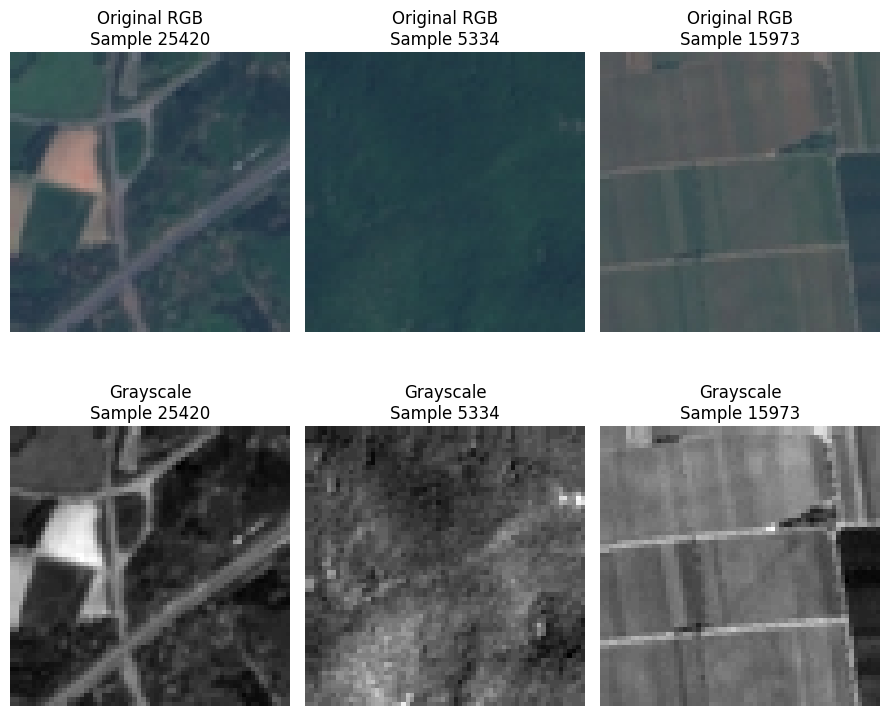

In [69]:
def plot_comparison_grid(original, grayscale, num_examples=3):
    plt.figure(figsize=(9, 8))

    # Create a grid: 2 rows (RGB top, grayscale bottom), num_examples columns
    for i in range(num_examples):
        idx = random.randint(0, len(original)-1)

        # Top row: RGB images
        plt.subplot(2, num_examples, i+1)  # 2 rows, num_examples cols, position i+1
        plt.imshow(original[idx].reshape(64, 64, 3))
        plt.title(f"Original RGB\nSample {idx}")
        plt.axis('off')

        # Bottom row: Grayscale versions
        plt.subplot(2, num_examples, i+1 + num_examples)  # Same column, next row
        plt.imshow(grayscale[idx].reshape(64, 64), cmap='gray')
        plt.title(f"Grayscale\nSample {idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot 3 examples in grid format
plot_comparison_grid(x_train, x_train_gray, num_examples=3)

## 2. Traditional Machine Learning

For this first section, we will only use the categories **"Forest (F)", "Residential (R)" and "Industrial (I)"**. Subset the grayscale dataset, select only for these three classes.

In [103]:
# Identify our target classes and their original indices
target_classes = ['Forest', 'Residential', 'Industrial']
target_indices = [class_names.index(cls) for cls in target_classes]  # Get original indices

# Create a mask for the target_indices in the training set
train_mask = np.isin(y_train, target_indices)

# Apply the mask to filter X_train and y_train
X_train_gray_sub = x_train_gray[train_mask]
y_train_sub = y_train[train_mask]

# Create a mask for the target_indices in the testing set
test_mask = np.isin(y_test, target_indices)

# Apply the mask to filter X_test and y_test
X_test_gray_sub = x_test_gray[test_mask]
y_test_sub = y_test[test_mask]

# Print the shapes of the sub datasets
print(f"Sub Training Data Shape: {X_train_gray_sub.shape}")
print(f"Sub Testing Data Shape: {X_test_gray_sub.shape}")

Sub Training Data Shape: (10200, 4096)
Sub Testing Data Shape: (6800, 4096)


### 2.1 Binary Support Vector Machine

Implement three binary SVM classifiers (use a linear kernel and default parameters) to classify [F vs R], [F vs I] and [R vs I].

In [109]:
F, R, I = 1, 7, 4  # Forest=1, Residential=7, Industrial=4

# 1. Forest vs Residential classifier
fr_mask = (y_train_sub == F) | (y_train_sub == R)
svm_fr = SVC(kernel='linear', random_state=42).fit(
    X_train_gray_sub[fr_mask],
    (y_train_sub[fr_mask] == F).astype(int)  # 1 for Forest, 0 for Residential
)

# 2. Forest vs Industrial classifier
fi_mask = (y_train_sub == F) | (y_train_sub == I)
svm_fi = SVC(kernel='linear', random_state=42).fit(
    X_train_gray_sub[fi_mask],
    (y_train_sub[fi_mask] == F).astype(int)  # 1 for Forest, 0 for Industrial
)

# 3. Residential vs Industrial classifier
ri_mask = (y_train_sub == R) | (y_train_sub == I)
svm_ri = SVC(kernel='linear', random_state=42).fit(
    X_train_gray_sub[ri_mask],
    (y_train_sub[ri_mask] == R).astype(int)  # 1 for Residential, 0 for Industrial
)

# Verify shapes
print("Classifier training samples:")
print(f"F vs R: {X_train_gray_sub[fr_mask].shape[0]} samples")
print(f"F vs I: {X_train_gray_sub[fi_mask].shape[0]} samples")
print(f"R vs I: {X_train_gray_sub[ri_mask].shape[0]} samples")

Classifier training samples:
F vs R: 7200 samples
F vs I: 6600 samples
R vs I: 6600 samples


Report the accuracy of each classifier, plot their ROC curves, calculate the AUCs.

In [110]:
# Calculate ROC curves
# F vs R
fr_mask = (y_test_sub == F) | (y_test_sub == R)
y_true_fr = (y_test_sub[fr_mask] == F).astype(int)
y_score_fr = svm_fr.decision_function(X_test_gray_sub[fr_mask])
fpr_fr, tpr_fr, _ = roc_curve(y_true_fr, y_score_fr)
auc_fr = auc(fpr_fr, tpr_fr)

# F vs I
fi_mask = (y_test_sub == F) | (y_test_sub == I)
y_true_fi = (y_test_sub[fi_mask] == F).astype(int)
y_score_fi = svm_fi.decision_function(X_test_gray_sub[fi_mask])
fpr_fi, tpr_fi, _ = roc_curve(y_true_fi, y_score_fi)
auc_fi = auc(fpr_fi, tpr_fi)

# R vs I
ri_mask = (y_test_sub == R) | (y_test_sub == I)
y_true_ri = (y_test_sub[ri_mask] == R).astype(int)
y_score_ri = svm_ri.decision_function(X_test_gray_sub[ri_mask])
fpr_ri, tpr_ri, _ = roc_curve(y_true_ri, y_score_ri)
auc_ri = auc(fpr_ri, tpr_ri)

<Figure size 800x600 with 0 Axes>

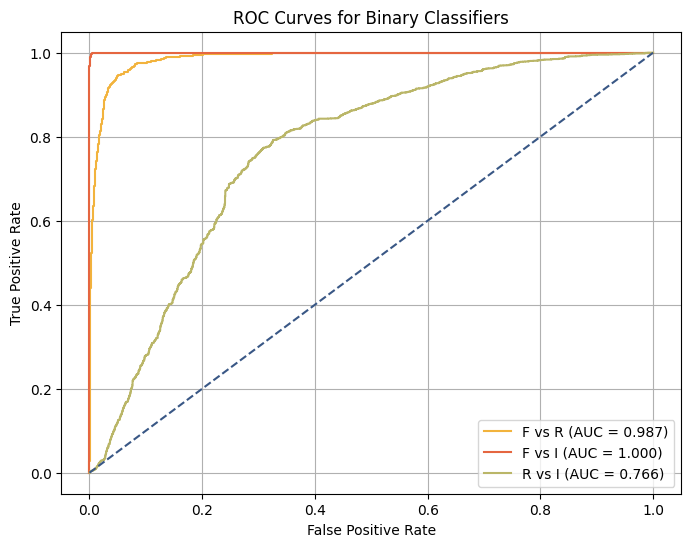

In [115]:
plt.figure(figsize=(8, 6))

# Plot all curves together
plt.plot(fpr_fr, tpr_fr, label=f'F vs R (AUC = {auc_fr:.3f})', color='#f2b33d')
plt.plot(fpr_fi, tpr_fi, label=f'F vs I (AUC = {auc_fi:.3f})', color='#E56640')
plt.plot(fpr_ri, tpr_ri, label=f'R vs I (AUC = {auc_ri:.3f})', color='#BAB668')

# Formatting
plt.plot([0, 1], [0, 1], color='#395785', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Binary Classifiers')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

In [116]:
# Print accuracies
print("Classifier Accuracies:")
print(f"F vs R: {accuracy_score(y_true_fr, svm_fr.predict(X_test_gray_sub[fr_mask])):.3f}")
print(f"F vs I: {accuracy_score(y_true_fi, svm_fi.predict(X_test_gray_sub[fi_mask])):.3f}")
print(f"R vs I: {accuracy_score(y_true_ri, svm_ri.predict(X_test_gray_sub[ri_mask])):.3f}")

Classifier Accuracies:
F vs R: 0.924
F vs I: 0.992
R vs I: 0.736


Show one image that is mis-classified by each classifier, including both the predicted label and the ground truth.

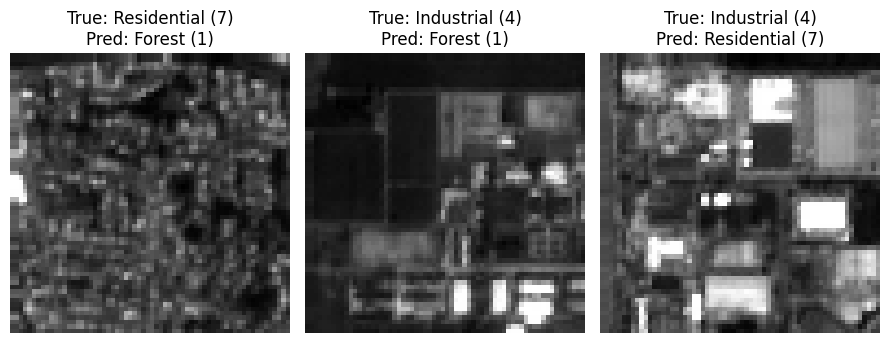

In [114]:
def plot_misclassified(classifier, X_test, y_test, class1, class2, class_names):
    """Find and plot first misclassified example"""
    mask = (y_test == class1) | (y_test == class2)
    X_sub = X_test[mask]
    y_true_sub = y_test[mask]

    # Get predictions (0 for class1, 1 for class2)
    y_pred = classifier.predict(X_sub)

    # Convert predictions to original labels
    y_pred_original = np.where(y_pred == 0, class1, class2)

    # Find first misclassified example
    misclassified = np.where(y_pred_original != y_true_sub)[0]
    if len(misclassified) > 0:
        idx = misclassified[0]
        img = X_sub[idx].reshape(64, 64)
        true_label = y_true_sub[idx]
        pred_label = y_pred_original[idx]

        plt.imshow(img, cmap='gray')
        plt.title(f"True: {class_names[true_label]} ({true_label})\nPred: {class_names[pred_label]} ({pred_label})")
        plt.axis('off')
    else:
        print(f"No misclassifications found for {class_names[class1]} vs {class_names[class2]}")

# Create mapping from indices to class names
class_names = {
    1: 'Forest',
    7: 'Residential',
    4: 'Industrial'
}

# Plot misclassified examples
plt.figure(figsize=(9, 4))

# 1. F vs R misclassification
plt.subplot(1, 3, 1)
plot_misclassified(svm_fr, X_test_gray_sub, y_test_sub, F, R, class_names)

# 2. F vs I misclassification
plt.subplot(1, 3, 2)
plot_misclassified(svm_fi, X_test_gray_sub, y_test_sub, F, I, class_names)

# 3. R vs I misclassification
plt.subplot(1, 3, 3)
plot_misclassified(svm_ri, X_test_gray_sub, y_test_sub, R, I, class_names)

plt.tight_layout()
plt.show()

### 2.2 Multiclass, Majority-Vote Support Vector Machine

Combine the three SVM models trained in the previous section to create a three-class classifier. The combined model will apply each one of the 3 classifiers on the testing data and will apply majority voting to decide the final class of the test sample.

In [122]:
# Define Majority Voting Function
def predict_three_class_sample(x):
    votes = []

    # Forest vs Residential (1 vs 7)
    pred_FR = svm_fr.predict(x.reshape(1, -1))[0]
    votes.append(1 if pred_FR == 1 else 7)

    # Forest vs Industrial (1 vs 4)
    pred_FI = svm_fi.predict(x.reshape(1, -1))[0]
    votes.append(1 if pred_FI == 1 else 4)

    # Residential vs Industrial (7 vs 4)
    pred_RI = svm_ri.predict(x.reshape(1, -1))[0]
    votes.append(7 if pred_RI == 7 else 4)

    # Majority vote
    final_pred = Counter(votes).most_common(1)[0][0]
    return final_pred

#Filter the Test Set for Classes [1, 7, 4]
mask_three = np.isin(y_test_sub, [1, 7, 4])
X_three = X_test_gray_sub[mask_three]
y_three = y_test_sub[mask_three]

# Predict on the 3-class test set using majority voting
y_pred_combined = np.array([predict_three_class_sample(x) for x in X_three])

# Accuracy
accuracy_combined = accuracy_score(y_three, y_pred_combined)
print(f"Three-Class Classifier Accuracy: {accuracy_combined * 100:.2f}%")

Three-Class Classifier Accuracy: 72.16%


Calculate the accuracy, ROC, and AUC.

In [126]:
# ROC/AUC calculation using target_indices
y_test_bin = label_binarize(y_three, classes=target_indices)

# Compute decision scores for each class
n_samples = len(X_three)
y_score = np.zeros((n_samples, len(target_indices)))

for i, x in enumerate(X_three):
    # Get decision scores from each binary classifier
    d_fr = svm_fr.decision_function([x])[0]  # F(1) vs R(7)
    d_fi = svm_fi.decision_function([x])[0]  # F(1) vs I(4)
    d_ri = svm_ri.decision_function([x])[0]  # R(7) vs I(4)

    # Calculate class scores (higher = more likely)
    y_score[i, 0] = (d_fr + d_fi) / 2         # Forest (1) score
    y_score[i, 1] = (-d_fr + d_ri) / 2        # Residential (7) score
    y_score[i, 2] = (-d_fi - d_ri) / 2        # Industrial (4) score

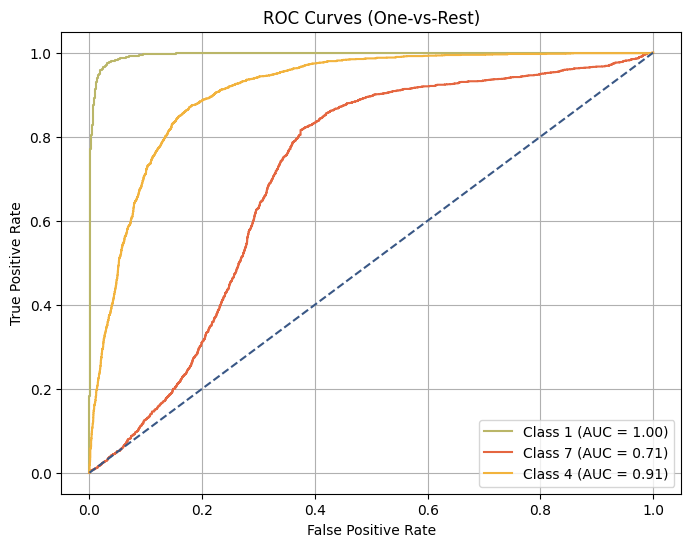

In [128]:
colors = ['#BAB668', '#E56640', '#f2b33d']

# Compute and plot ROC curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(target_indices):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC = {roc_auc:.2f})', color=colors[i % len(colors)])

plt.plot([0, 1], [0, 1], color='#395785', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Show a mis-classified image from each class, including both the predicted label and the ground truth.

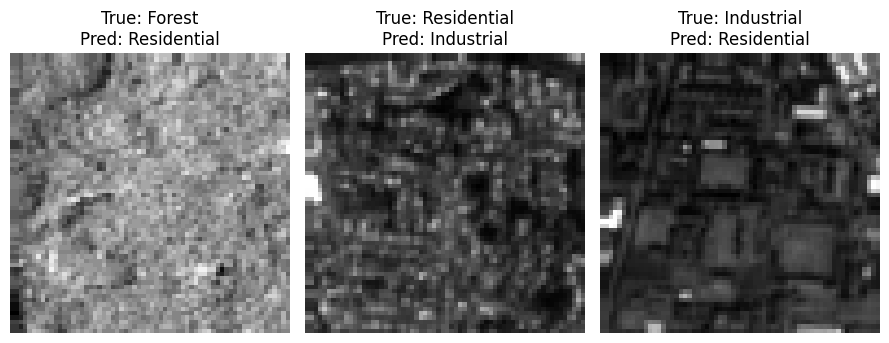

In [130]:
# Find first misclassified example for each class
misclassified = {}
for cls in target_indices:  # [1, 7, 4]
    for i, (x, true_label) in enumerate(zip(X_three, y_three)):
        if true_label == cls and y_pred_combined[i] != true_label:
            misclassified[cls] = (x, true_label, y_pred_combined[i])
            break

# Plot misclassified images with class names
plt.figure(figsize=(9, 4))
for idx, cls in enumerate(target_indices):
    if cls in misclassified:
        x, true_label, pred_label = misclassified[cls]
        plt.subplot(1, 3, idx+1)
        plt.imshow(x.reshape(64, 64), cmap='gray')
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
        plt.axis('off')
    else:
        print(f"No misclassifications found for {class_names[cls]}")

plt.tight_layout()
plt.show()

### 2.3 Multiclass Random Forest

Train a Random-Forest classifier to classify the data into one of the three classes.

In [132]:
# 1. Initialize Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=10,      # Maximum tree depth
    random_state=42,   # For reproducibility
    class_weight='balanced'  # Handles class imbalance
)

# 2. Train on 3-class subset
rf_clf.fit(X_train_gray_sub, y_train_sub)

# 3. Predict on test set
y_pred_rf = rf_clf.predict(X_test_gray_sub)

# 4. Evaluate
accuracy = accuracy_score(y_test_sub, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test_sub, y_pred_rf,
                          target_names=['Forest (1)',
                                       'Residential (7)',
                                       'Industrial (4)']))

Random Forest Accuracy: 0.896

Classification Report:
                 precision    recall  f1-score   support

     Forest (1)       0.98      0.97      0.98      2400
Residential (7)       0.85      0.86      0.85      2000
 Industrial (4)       0.85      0.85      0.85      2400

       accuracy                           0.90      6800
      macro avg       0.89      0.89      0.89      6800
   weighted avg       0.90      0.90      0.90      6800



Plot the confusion matrix, and print a mis-classified image from each class, including both the predicted label and the ground truth.

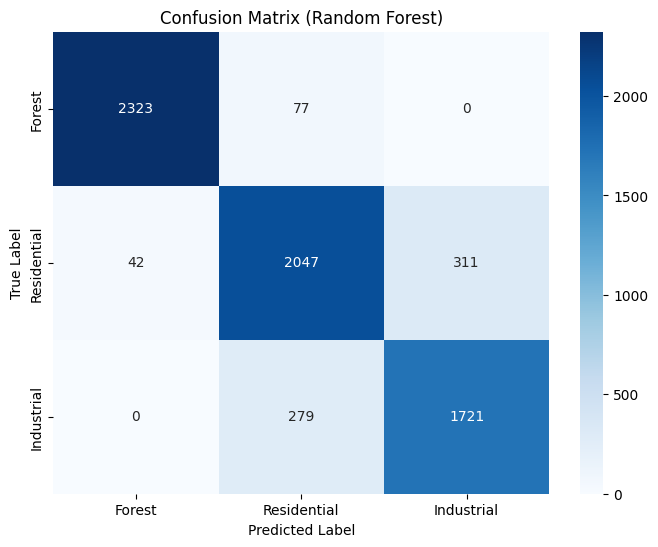

In [135]:
cm = confusion_matrix(y_test_sub, y_pred_rf, labels=[1, 7, 4])

# Plot with class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[class_names[cls] for cls in [1, 7, 4]],
            yticklabels=[class_names[cls] for cls in [1, 7, 4]])
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

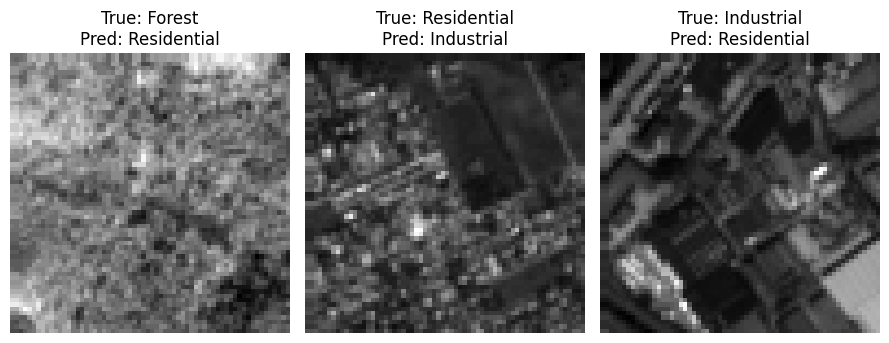

In [137]:
# Find first misclassified example for each class
misclassified_examples = []
for true_class in [1, 7, 4]:
    # Find indices where true_class was misclassified
    misclassified_idx = np.where((y_test_sub == true_class) & (y_pred_rf != y_test_sub))[0]

    if len(misclassified_idx) > 0:
        # Take the first misclassified example
        idx = misclassified_idx[0]
        img = X_test_gray_sub[idx].reshape(64, 64)
        true_label = y_test_sub[idx]
        pred_label = y_pred_rf[idx]
        misclassified_examples.append((img, true_label, pred_label))
    else:
        print(f"No misclassifications found for {class_names[true_class]}")

# Plot the misclassified examples
plt.figure(figsize=(9, 4))
for i, (img, true_label, pred_label) in enumerate(misclassified_examples):
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3. Deep Learning

For this section, we will use the full range of possible land cover categories, so do not filter the training and testing datasets for only certain labels.

### 3.1 Greyscale Images

For this section, use the same greyscale images that you used in the traditional machine learning section.

#### 3.1.1 Model One

Implement a first deep learning model using a fully connected network with a single fully connected layer (i.e: input layer + fully connected layer as the output layer). [Visualize the network architecture](https://faroit.com/keras-docs/2.0.8/visualization/). Calculate classification accuracy on the test data.

In [139]:
# 1. Prepare Data (using existing grayscale images)

# Normalize pixel values to [0,1]
x_train = x_train_gray.astype('float32') / 255.0
x_test = x_test_gray.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

# 2. Build Model
model = keras.Sequential([
    layers.Input(shape=(4096,)),  # Input layer for flattened 64x64 images
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes
])

# 3. Visualize Architecture
plot_model(model, to_file='single_layer_fc.png', show_shapes=True)
print("Model architecture saved as single_layer_fc.png")

# 4. Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Train Model
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_test, y_test))

# 6. Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\nTest accuracy: {test_acc:.4f}')

Model architecture saved as single_layer_fc.png
Epoch 1/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1298 - loss: 2.3435 - val_accuracy: 0.1391 - val_loss: 2.2790
Epoch 2/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1717 - loss: 2.2433 - val_accuracy: 0.1626 - val_loss: 2.2421
Epoch 3/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2082 - loss: 2.2052 - val_accuracy: 0.1708 - val_loss: 2.2682
Epoch 4/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2162 - loss: 2.1877 - val_accuracy: 0.2728 - val_loss: 2.2201
Epoch 5/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.2316 - loss: 2.1423 - val_accuracy: 0.2265 - val_loss: 2.1764
Epoch 6/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2430 - loss: 2.1395 - val_accuracy: 0.2312 - val_loss: 2.1945
Epoch 7/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.2515 - loss: 2.1018 - val_accuracy: 0.2216 - val_loss: 2.1730
Epoch 8/10
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - a

In [143]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,912 (480.13 KB)

 Trainable params: 40,970 (160.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,942 (320.09 KB)

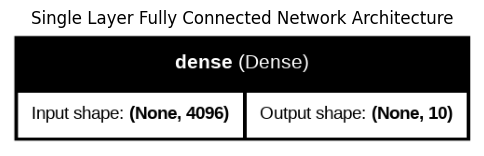

In [142]:
# Visualize the architecture with better formatting
plot_model(
    model,
    to_file='single_layer_fc.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='LR',  # Left-to-right orientation
    dpi=96,
    layer_range=None,
    expand_nested=False
)

# Display the image in notebook
img = plt.imread('single_layer_fc.png')
plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Single Layer Fully Connected Network Architecture')
plt.show()

**What kind of pre-processing might be necessary so that this model and the subsequent ones can handle categorical labels? Why?**

To handle categorical labels effectively in deep learning models, preprocessing must ensure labels are interpreted as discrete categories rather than numerical values. The most critical step is one-hot encoding, which converts integer class labels (e.g., 0, 1, 2) into binary vectors (e.g., [1, 0, 0], [0, 1, 0]), eliminating any false ordinal relationships that could mislead the model.

#### 3.1.2 Model Two

Implement a second deep learning model adding an additional fully connected hidden layer (with an arbitrary number of nodes) to the previous model. Visualize the network architecture. Calculate classification accuracy on the test data. How did adding an additional hidden layer affect your model's performance? Why might additional hidden layers improve or potentially worsen accuracy?

#### 3.1.3 Model Three

Implement a third deep learning model adding two additional fully connected hidden layers (with arbitrary number of nodes) for a total of four, as well as drop-out layers to the previous model. Visualize the network architecture. Calculate classification accuracy on the test data. What did you observe about the impact of dropout layers on the model’s performance? Explain how dropout helps in model training and under what circumstances it might be more or less effective.

#### 3.1.4 Model Comparison

Compare models one through three. Which network had the most parameters to learn, and by what margin? Which model was the "best"? Why? For each model, what is the impact of increasing the number of training epochs?

**Bonus:** Implement an ensemble model that incorporates the predictions of models one through three. Calculate its classification accuracy on the test data. How does this compare to the accuracies of the three individual model? Describe the ensemble approach you implemented. Why might ensembling improve model accuracy compared to the individual models?

### 3.2 RGB Images

For this section, use the original RGB images.

#### 3.2.1 Model Four

Implement a fourth deep learning model, a convolution neural network (CNN) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. Visualize the network architecture. Calculate classification accuracy on the test data. Compare against previous models. Which model was the "best"? Why? Did you notice any limitations in terms of training speed compared to the previous models?

How does the CNN model handle spatial information differently than the fully connected models? What implications does this have for image classification? Compare the training speed of CNNs with the fully connected networks. Why do CNNs generally require more computational resources?

#### 3.2.2 Model Five

Implement a fifth deep learning model targeting accuracy that will outperform all previous models. You are free to use any tools and techniques, including ensemble models and pre-trained models for transfer learning. Calculate classification accuracy on the test data. What specific tools or techniques did you choose to improve accuracy? Why did you select these approaches over others? Compare against previous models. Which model was the "best"? Why?

What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples. Why do you think this is? Can you think of any strategies or approaches that might help to address this issue?

### 3.3 Multispectral Images

Apply your best model on multispectral images. You may use whichever image channels you wish, so long as you use more than just RGB (although you are not required to use any color channels). Calculate classification accuracy on the test data. Compare against results using RGB images.

How did adding multispectral channels impact your model’s performance? Explain the role of additional spectral information in enhancing land cover classification.


## 4. Reflection Questions

What are your takeaways from tuning the parameters of the different models? What are your observations about increasing the number of training epochs? Did you run into any challenges or limitations when doing this? What was the impact of using dropout? If you answered the bonus questions, how did the ensemble models compare to the other models? What kinds of challenges or limitations did you encounter when preparing and training the models for this assignment, and how might you address them in the future? How might you apply what you've learned about model tuning, dropout, and data processing to a different deep learning problem?